# Introduction

Listen up, folks! You know how they say dinosaurs are extinct? Well, they lied to us. The DINO model is proof that these ancient beasts are still roaming the earth, but this time, they're here to help us with feature extraction and downstream tasks. Imagine a T-Rex with a fancy deep learning algorithm strapped to its back, stomping around and making sense of all the data in its path.

But wait, it gets better! This dino doesn't just extract features; it does it in a self-supervised manner, which means it's like a kid who learned to tie its own shoelaces without any help from its parents (or, in this case, labeled data). And once it's done extracting those juicy features, it's ready to tackle any downstream task you throw its way, whether it's image classification, object detection, or even predicting the next hot dinosaur-themed movie.

In this homework assignment, we will be utilizing the DINO model to extract meaningful visual features from satellite imagery data. The self-supervised DINO model has proven to be an effective tool for extracting rich representations from visual data without the need for labeled examples during pre-training.

Specifically, we will leverage the DINO model's capabilities to extract visual features from satellite images. These extracted features will then be used to train a classifier on top of the DINO backbone. The goal of this classifier is to predict whether a given satellite image contains solar panels or not.

Moving on to the second part of the assignment, we will explore the transformer attention maps produced by the DINO model. By analyzing these attention maps, we aim to estimate the size of the solar panels present in the positive examples from the dataset.

While not as exhilarating as envisioning a dinosaur with deep learning capabilities, this assignment presents an opportunity to gain hands-on experience with a state-of-the-art self-supervised model and its applications in computer vision tasks. I'm sure you'll find the process insightful and rewarding.

# Installations and imports

As usual, imports are our first step.

In [ ]:
!pip install gdown

In [ ]:
!pip install einops

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 77.1 MB/s eta 0:00:00


In [1]:
import os
import glob
import torch
import gdown
import rasterio
import numpy as np
import einops as eo
import random as rnd
import torch.nn as nn
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib.colors import Normalize
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Dataset

In [2]:
gdown.download("https://drive.google.com/uc?id=1AgBzfGrOSEcuItEGBv7VpSw6bfJBichK&export=download", "uk20K.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1AgBzfGrOSEcuItEGBv7VpSw6bfJBichK&export=download
From (redirected): https://drive.google.com/uc?id=1AgBzfGrOSEcuItEGBv7VpSw6bfJBichK&export=download&confirm=t&uuid=bd05ba80-6c6d-4305-a8e6-4230e8841090
To: /content/uk20K.zip
100%|██████████| 1.92G/1.92G [00:19<00:00, 99.9MB/s]


'uk20K.zip'

In [ ]:
!unzip uk20K.zip

Let's prepare the train and validation datasets.

In [4]:
def normalize(image, MEAN = [0.485, 0.456, 0.406], STD = [0.485, 0.456, 0.406]):
    image = image / 255
    source, dest = 0 if len(image.shape) == 3 else 1, -1
    return np.moveaxis((np.moveaxis(image, source, dest) - MEAN) / STD, dest, source)

def denormalize(image, MEAN = [0.485, 0.456, 0.406], STD = [0.485, 0.456, 0.406]):
    source, dest = 0 if len(image.shape) == 3 else 1, -1
    image = np.moveaxis((np.moveaxis(image, source, dest) * STD) + MEAN, dest, source)
    return (image * 255).astype(int)


class SolarDataset(Dataset):
    def __init__(self, file_names):
        self.file_names = file_names

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        path = self.file_names[index]
        x = rasterio.open(self.file_names[index]).read()
        y = torch.tensor(1.0).long() if path.endswith('-P.tif') else torch.tensor(0.0).long()
        x = normalize(x, MEAN=[0.5, 0.5, 0.5], STD=[0.5, 0.5, 0.5])
        return torch.as_tensor(x.copy()).float(), y, self.file_names[index]

The dataset comprises of .tif image files. The images are labeled based on the presence or absence of solar panels within them. If an image's filename ends with "-P" it indicates a positive label, signifying that the image contains at least one solar panel. Conversely, if the filename ends with "-N" it denotes a negative label, implying that no solar panels are present in the image. However, the dataset does not provide any details regarding the size of the solar panels in the images.

Split the dataset into train and test sets and create the dataloaders.

In [16]:
# List files in dataset directory
dataset_directory = "uk20K_v2"
file_paths = glob.glob(os.path.join(dataset_directory, "*.tif"))

# Split dataset into training and testing
train_files, test_files = train_test_split(file_paths, test_size=0.2, random_state=42)

# Create dataset instances
train_dataset = SolarDataset(train_files)
test_dataset = SolarDataset(test_files)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model definition

This section focuses on defining the models. The first component is a DINO backbone, which serves as a feature extractor. The code for DINO is already written and does not require any modifications. The second component is a classifier head that will be placed on top of the DINO features. The init function for this model has been provided, and your task is to complete the forward method.

In [6]:
class DinoBackbone(nn.Module):
    def __init__(self, dino_size='small') -> None:
        super().__init__()
        if dino_size == 'small':
            self.dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
            self.d_model = 384
        elif dino_size == 'base':
            self.dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
            self.d_model = 768
        elif dino_size == 'giant':
            self.dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')
            self.d_model = 1536

    def forward(self, x):
        x = self.dinov2.forward_features(x)
        cls_token = x["x_norm_clstoken"]
        patch_tokens = x["x_norm_patchtokens"]
        return cls_token, patch_tokens

In [7]:
class TransformerEncoderLinearHead(nn.Module):

    def __init__(self, d_model, output_size) -> None:
        super().__init__()
        self.transformer = nn.TransformerEncoderLayer(d_model, 8, batch_first=True)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x_feats):
        cls_embs, patch_embs = x_feats

        # Concatenate cls_embs and patch_embs along the sequence dimension (dim=1)
        x = torch.cat([cls_embs.unsqueeze(1), patch_embs], dim=1)

        # Pass the concatenated embeddings through the transformer encoder
        x = self.transformer(x)

        # Extract the cls token output (the first token in the sequence)
        cls_token_out = x[:, 0]

        # Pass the cls token output through the linear layer
        output = self.fc(cls_token_out)

        return output
    def get_size_estimate(self, x_feats, vis=False, images=None):
        cls_embs, patch_embs = x_feats

        # Concatenate cls_embs and patch_embs along the sequence dimension (dim=1)
        x = torch.cat([cls_embs.unsqueeze(1), patch_embs], dim=1)

        # Get the self-attention maps from the transformer
        attn_output, attn_weights = self.transformer.self_attn(x, x, x, need_weights=True)

        if attn_weights.dim() == 3:
          # If batch size is 1, add a batch dimension
          attn_weights = attn_weights.unsqueeze(0)

        # Extract the attention of cls token with all patch tokens (h x 256)
        cls_attn = attn_weights[:, :, 0, 1:]  # shape: batch_size x num_heads x 256


        # Reshape to h x 16 x 16 (assuming patch grid is 16x16)
        cls_attn = cls_attn.view(cls_attn.size(0), cls_attn.size(1), 16, 16)  # shape: batch_size x num_heads x 16 x 16

        # Upsample to 224x224
        cls_attn_upsampled = nn.functional.interpolate(cls_attn, scale_factor=14, mode='bilinear', align_corners=False)  # shape: batch_size x num_heads x 224 x 224

        # Sum across heads (shape: batch_size x 224 x 224)
        cls_attn_sum = cls_attn_upsampled.sum(dim=1)

        # Normalize the attention map to the range [0, 1]
        cls_attn_normalized = cls_attn_sum / cls_attn_sum.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]

        # Apply a threshold to create a binary mask
        threshold = 0.5  # Adjust this threshold as needed
        binary_mask = (cls_attn_normalized > threshold).float()

        h, w = cls_attn_normalized.shape[-2:]  # Get the height and width from the attention map
        # If visualization is requested, generate the attention maps
        visualization_images = []
        if vis and images is not None:
            for i in range(images.shape[0]):
                img = images[i].detach().cpu().numpy().transpose((1, 2, 0))
                normalized_img = Normalize(vmin=img.min(), vmax=img.max())(img)

                # Overlay attention on image
                attention = cls_attn_normalized[i].detach().cpu().numpy()
                reds = plt.cm.Reds(attention)
                alpha_max_value = 1.00
                gamma = 0.5

                rgba_img = np.zeros((h, w, 4))
                rgba_img[..., :3] = normalized_img
                rgba_img[..., 3] = 1

                rgba_mask = np.zeros((h, w, 4))
                rgba_mask[..., :3] = reds[..., :3]
                rgba_mask[..., 3] = np.power(attention, gamma) * alpha_max_value

                rgba_all = np.zeros((h, w*2, 4))  # Side by side visualization
                rgba_all[:, :224, :] = rgba_img
                rgba_all[:, 224:, :] = rgba_mask

                visualization_images.append(rgba_all)

        # Estimate size based on the binary mask
        counts = binary_mask.sum((1, 2))
        return counts, visualization_images

# Train

Now initialize the model, define the optimizer and loss function and train the classifier model. Train your model for 2 epochs (this should be pretty fast). Pay attention that your code produces similar output as the one in the notebook so that training loss and validation accuracy are reported.

In [11]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

backbone = DinoBackbone(dino_size='small')
backbone = backbone.to(device)
backbone.eval()
head = TransformerEncoderLinearHead(backbone.d_model, 2)
head = head.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [12]:
lr = 0.001
optimizer = torch.optim.Adam(head.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [17]:
from tqdm import tqdm

num_epochs = 5
running_loss = 0

# Training loop
for epoch in range(num_epochs):
    head.train()  # Set the model to training mode

    running_loss = 0.0

    for images, labels, _ in tqdm(train_loader):  # Use the train_loader
        images, labels = images.to(device), labels.to(device)

        # Extract features from DINO backbone
        with torch.no_grad():  # Freeze the DINO backbone
            x_feats = backbone(images)

        # Forward pass through the classifier head
        outputs = head(x_feats)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * images.size(0)

    # Print loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

torch.save(head.state_dict(), 'final_model.pth')

100%|██████████| 500/500 [02:14<00:00,  3.73it/s]


Epoch 1/5, Loss: 0.2034


100%|██████████| 500/500 [02:16<00:00,  3.66it/s]


Epoch 2/5, Loss: 0.1927


100%|██████████| 500/500 [02:11<00:00,  3.81it/s]


Epoch 3/5, Loss: 0.1818


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


Epoch 4/5, Loss: 0.1770


100%|██████████| 500/500 [02:17<00:00,  3.65it/s]

Epoch 5/5, Loss: 0.1736


In [18]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

backbone = DinoBackbone(dino_size='small')
backbone = backbone.to(device)
backbone.eval()
head = TransformerEncoderLinearHead(backbone.d_model, 2)
head.load_state_dict(torch.load('final_model.pth'))
head = head.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Now go through the validation set and for every image predict whether it contains solar panel or not. Then from all the images that contain solar panels, visualize some that have the large panels and some with the small panels based on your size estimation module. Your outputs should be something like the following. Remeber: you have to look at size estimates only for images that are predicted positive (contain solar panel.) The size estimation module doesn't work for negative images (There are no panels to estimate their size).

In [19]:
# Step 1: Run Inference on the Validation Set
positive_images = []
positive_sizes = []
positive_visuals = []

head.eval()  # Set the classifier model to evaluation mode

correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Disable gradient computation
    for images, labels, paths in tqdm(test_loader):  # Use the validation data loader
        images, labels = images.to(device), labels.to(device)

        # Extract DINO features
        dino_feats = backbone(images)

        # Predict with the classifier
        outputs = head(dino_feats)
        _, preds = torch.max(outputs, 1)

        # Update the accuracy statistics
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        # Process each image in the batch individually
        for i in range(len(preds)):
            if preds[i] == 1:  # If the model predicts solar panels
                cls_feat = dino_feats[0][i:i+1]  # Extract class embedding
                patch_feat = dino_feats[1][i:i+1]  # Extract patch embeddings
                single_image = images[i:i+1]  # Get the original image

                # Estimate size and generate visualization for the current positive example
                size, visual = head.get_size_estimate((cls_feat, patch_feat), vis=True, images=single_image)

                # Store the results
                positive_sizes.append(size.item())
                positive_visuals.append(visual[0])  # Assuming visual is a list of 1 element

# Step 2: Sort the Positive Images by Estimated Size
positive_sizes = np.array(positive_sizes)
sorted_indices = np.argsort(positive_sizes)
smallest_indices = sorted_indices[:5]  # Smallest 5
largest_indices = sorted_indices[-5:]  # Largest 5

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 125/125 [00:45<00:00,  2.72it/s]



Test Accuracy: 92.65%


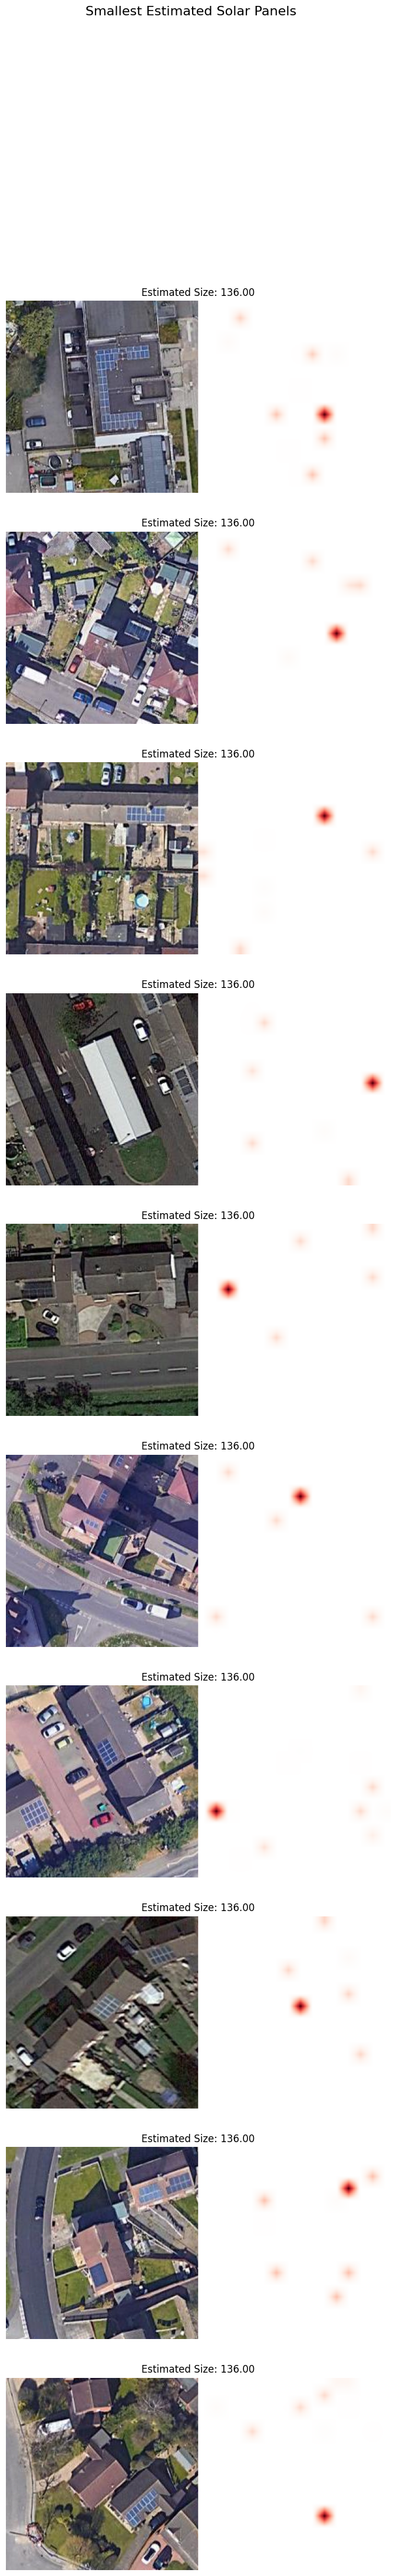

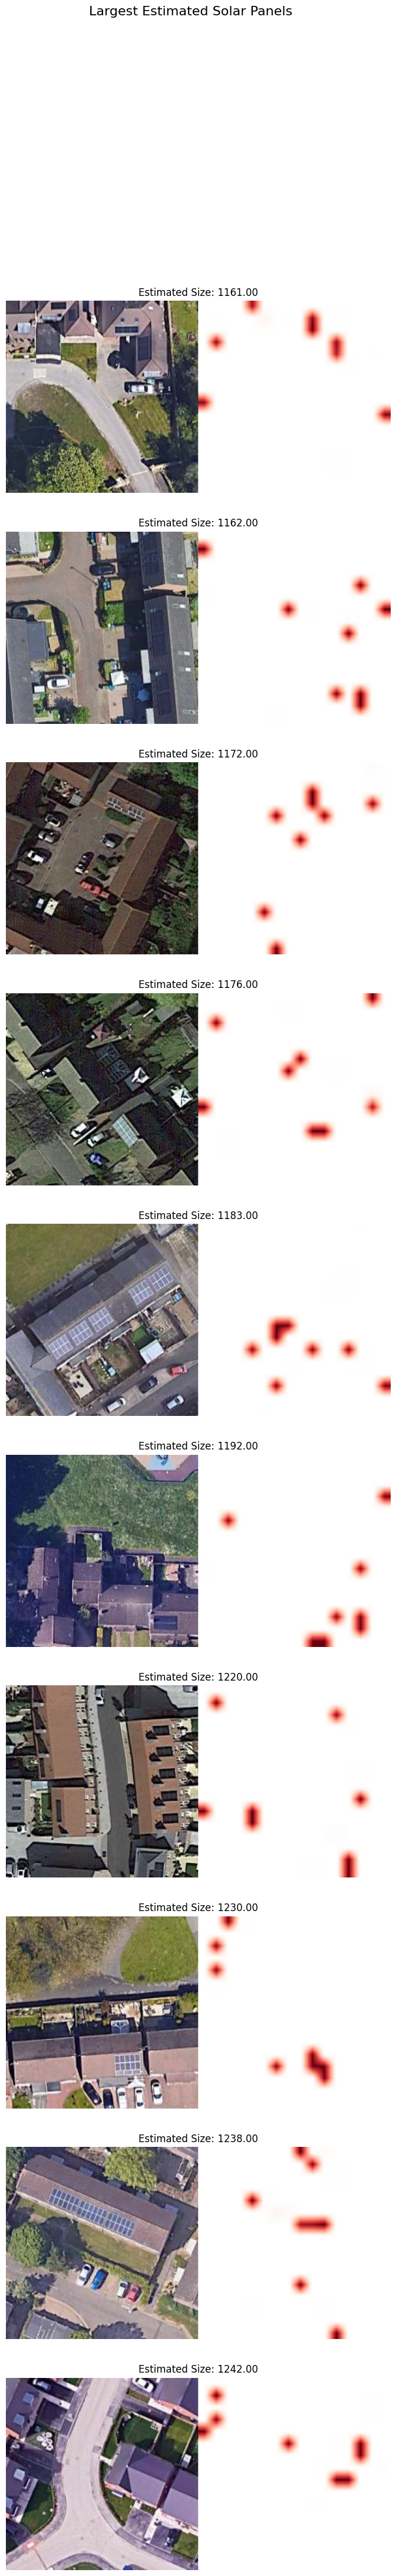

In [22]:
# Step 3: Visualize the Smallest and Largest Solar Panels
import matplotlib.pyplot as plt

# Step 3: Visualize the Smallest and Largest Solar Panels
import matplotlib.pyplot as plt

def visualize_examples(indices, title):
    fig, axes = plt.subplots(len(indices), 1, figsize=(10, len(indices) * 5))
    fig.suptitle(title, fontsize=16)

    for i, idx in enumerate(indices):
        attention_visual = positive_visuals[idx]
        panel_size = positive_sizes[idx]

        # Display attention map overlay
        axes[i].imshow(attention_visual)
        axes[i].axis('off')
        axes[i].set_title(f'Estimated Size: {panel_size:.2f}', fontsize=12)

    plt.show()

# Visualize Smallest Solar Panels
visualize_examples(smallest_indices, 'Smallest Estimated Solar Panels')

# Visualize Largest Solar Panels
visualize_examples(largest_indices, 'Largest Estimated Solar Panels')
